In [1]:
import numpy as np
import pandas as pd
import time, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split as split

import random
from math import floor
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from scipy.integrate import odeint
import scipy
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
df=pd.read_csv('data/jla.csv')
N = len(df.values)
randomize = np.random.permutation(N)
data = df.values[randomize]
N = len(df.values)
z = data[:,0] 
y = data[:,1:3] ### coge el resto de variables a predecir 
y[:,1] = y[:,1]**2+data[:,2]
np.shape(y)
df

,zcmb,mb,dmb,errors
0,0.503084,23.001698,0.088031,0.120219
1,0.580724,23.573937,0.090132,0.121435
2,0.494795,22.960139,0.088110,0.089552
3,0.345928,22.398137,0.087263,0.119729
4,0.677662,24.078115,0.098356,0.100088
...,...,...,...,...
735,0.027064,16.504006,0.141685,0.185894
736,0.025468,15.797848,0.143429,0.193666
737,0.023810,15.895501,0.144315,0.184957
738,0.023867,16.068268,0.144350,0.175960


In [3]:
dmag =df["dmb"]

df2=df['errors']+df['dmb']**2

In [4]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
z = scalerz.transform(z.reshape(-1,1))

In [5]:
### Modificar para incluir phanteon como test
split = 0.75
ntrain = int(split * len(z))
indx = [ntrain]
X_train, X_test = np.split(z, indx)
Y_train, Y_test = np.split(y, indx)
np.shape(X_train), np.shape(X_test), Y_train.shape, Y_test.shape

((555, 1), (185, 1), (555, 2), (185, 2))

In [6]:
# loss -> val_loss
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=100,
                                   restore_best_weights=True, verbose=False)
                                   ]

n_cols = 1

In [7]:
epochs=500

In [8]:
def train_test_model(hparams):    
    
    # Train LSTM model and predict on validation set
    model = tf.keras.Sequential()
    model.add(Dense(int(X_train.shape[1])))
    
    for i in range(hparams['HP_LAYERS']):        
        model.add(Dense(hparams['HP_NUM_UNITS'], activation='relu'))
    model.add(Dense(2, activation='linear'))
     
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['HP_LEARNING'], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(
            optimizer=optimizer,
            loss='mse', 
            metrics=['mean_squared_error'])
    
    # Run with 1 epoch to speed things up for demo purposes

    train = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test),
              callbacks=callbacks, batch_size=hparams['HP_BATCHSIZE'], shuffle=False, verbose=False)

    _, loss = model.evaluate(X_test, Y_test)
    
    return model, loss, train.history

# Grid results

- layers:3
- nodes: 200
- lr: 0.00010
- bs = 16

loss = 0.031342 	

In [31]:
hparams = {'HP_LAYERS': 3, 'HP_NUM_UNITS': 200, 'HP_BATCHSIZE': 16, 'HP_LEARNING':0.0001}

In [32]:
model, loss_test, history = train_test_model(hparams)

6/6 [==============================] - 0s 2ms/step - loss: 0.0348 - mean_squared_error: 0.0348


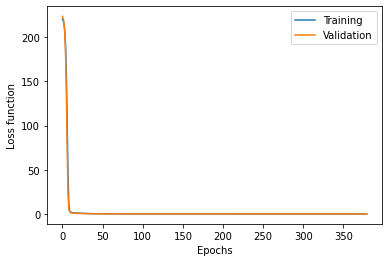

In [33]:
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.ylabel('Loss function')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

In [34]:
loss_test

0.03479311242699623

# Genetic results
3 	100 	0.0001 	8 	
- layer = 3 	
- nodes = 100 	
- lr = 0.00010 	
- bs = 4

loss = 0.029919 	
<!-- 3 	100 	0.0001 	4 	0.029919 	0.029919 	 -->

In [35]:
hparams_gen = {'HP_LAYERS': 3, 'HP_NUM_UNITS': 100, 'HP_BATCHSIZE': 4, 'HP_LEARNING':0.0001}

In [36]:
model_gen, loss_test_gen, history_gen = train_test_model(hparams_gen)

6/6 [==============================] - 0s 1ms/step - loss: 0.0334 - mean_squared_error: 0.0334


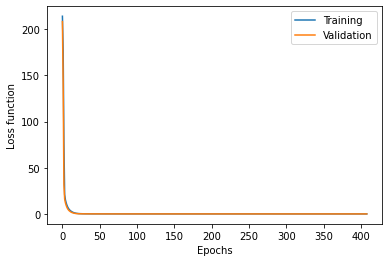

In [37]:
plt.plot(history_gen['loss'], label='Training')
plt.plot(history_gen['val_loss'], label='Validation')
plt.ylabel('Loss function')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

In [38]:
loss_test_gen

0.03335219621658325

In [39]:
# ranz = np.random.uniform(0, 2, size=10000)
ranz = np.linspace(np.min(df['zcmb']), np.max(df['zcmb']), 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random_gen = model_gen.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
pred_random_grid = model.predict(r)


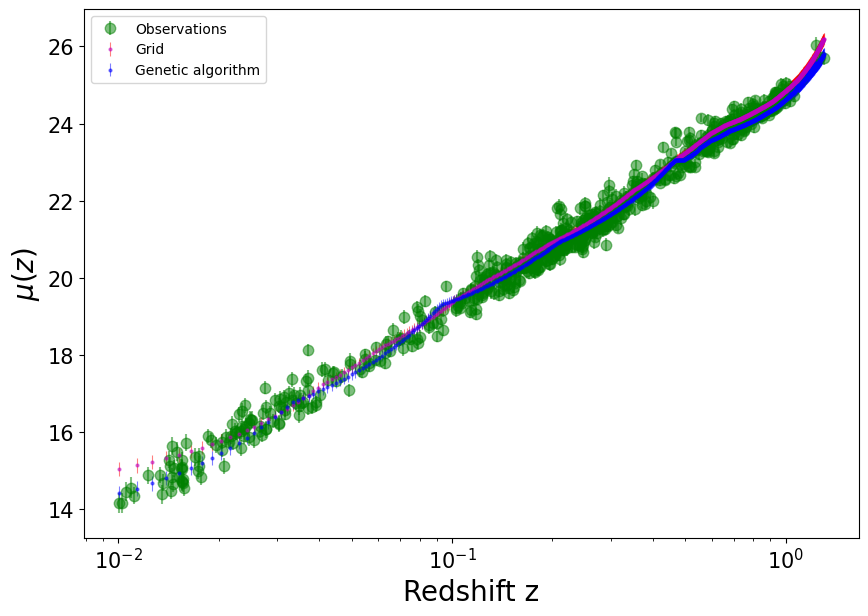

In [40]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb'], df2, fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random_grid[:,0], pred_random_grid[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m', label='Grid')
plt.errorbar(rr, pred_random_gen[:,0], pred_random_gen[:,1], markersize=2, fmt='o', 
             ecolor='b', capthick=2, elinewidth=0.8, alpha=0.5, c='b', label='Genetic algorithm')
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.xscale('log')

plt.ylabel("$\mu(z)$", fontsize=20)
# plt.xlim(1e-6, 1.3)
plt.savefig("jla_reconstruction.png")